In [1]:
import pandas as pd
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

pd.set_option('display.max_colwidth', None)#setting the maximize string show

fb = pd.read_csv('nysu_10902_2019_research_right.csv')
politics = pd.read_csv('9th_legislator_promise.csv')
fb.page_name.unique() #觀察人名在資料集中叫什麼名字
politics.姓名.unique()

array(['吳思瑤', '姚文智', '何志偉', '蔣萬安', '李彥秀', '林昶佐', '蔣乃辛', '費鴻泰', '賴士葆',
       '呂 孫 綾', '林 淑 芬', '高志鵬', '余天', '吳 秉 叡', '蘇 巧 慧', '張 宏 陸', '羅 致 政',
       '江 永 昌', '林 德 福', '吳 琪 銘', '羅 明 才', '黃 國 昌', '蔡適應', '鄭 運 鵬',
       '陳賴素美', '陳學聖', '鄭寶清', '呂玉玲', '趙正宇', '林為洲', '柯建銘', '陳超明', '徐志榮',
       '蔡其昌', '顏寬恒', '洪慈庸', '張廖萬堅', '盧秀燕', '沈智慧', '黃國書', '何欣純', '江啟臣',
       '王惠美', '柯呈枋', '黃秀芳', '洪宗熠', '陳素月', '馬 文 君', '許 淑 華', '蘇 治 芬',
       '劉 建 國', '李 俊 俋', '蔡 易 餘', '陳 明 文', '葉宜津', '黃偉哲', '郭國文  ', '陳亭妃',
       '林俊憲', '王定宇', '邱 議 瑩', '邱 志 偉', '劉 世 芳', '林 岱 樺', '管 碧 玲', '李 昆 澤',
       '趙 天 麟', '馬 凱 妮', '賴 瑞 隆', '蘇震清', '鍾佳濱', '莊瑞雄', '陳歐珀', '蕭美琴',
       '劉櫂豪', '楊 曜', '楊鎮浯', '陳玉珍', '陳雪生', '廖國棟', '鄭天財', '陳瑩', '高金素梅',
       '簡東明', '孔文吉', nan], dtype=object)

In [2]:
lo = fb[fb.page_name == "羅致政粉絲團"]
lo.head(1)

,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,link_name,link_description,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count
23477,182836328407031_2219870311370279,182836328407031,羅致政粉絲團,政治人物,違法兼職，事證明確，卡不卡管，台大自斷,NaN,link,https://www.facebook.com/182836328407031/posts/2219870311370279/,2019-01-15T06:40:53+0000,2019-01-15T14:40:53,...,管中閔違法兼職 監察院7：4通過彈劾 | 蘋果日報,台大校長管中閔已在上周上任，不過，對於他過去擔任學校主管及政府部門任職時在外兼職違法事宜，監察院今天召開管中閔兼職的彈劾審查，結果以7：4通...,1029,0,0,0,0,0,42,29


In [3]:
lo['new_date'] = pd.to_datetime(lo['created_time_taipei']).dt.date
lo['month_year'] = pd.to_datetime(lo['new_date']).dt.to_period('M')
lo.head(1)

<ipython-input-3-067a578daaf3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lo['new_date'] = pd.to_datetime(lo['created_time_taipei']).dt.date
<ipython-input-3-067a578daaf3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lo['month_year'] = pd.to_datetime(lo['new_date']).dt.to_period('M')


,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count,new_date,month_year
23477,182836328407031_2219870311370279,182836328407031,羅致政粉絲團,政治人物,違法兼職，事證明確，卡不卡管，台大自斷,NaN,link,https://www.facebook.com/182836328407031/posts/2219870311370279/,2019-01-15T06:40:53+0000,2019-01-15T14:40:53,...,1029,0,0,0,0,0,42,29,2019-01-15,2019-01


In [4]:
# 依照按讚數 低到高排序
lo = lo.sort_values(by=['like_count'])
# 用新的排序當作順序
lo.reset_index(inplace=True)

結巴斷詞 jieba

len(lo): 看羅致政的貼文總共有幾筆
list(lo['message']): 把要斷詞的內容轉成 list 格式
創造一個新的dataframe叫做lo_docs，型態是pandas.core.frame.DataFrame
原本liu_docs裡面的'jieba_results'欄位型態是pandas.core.series.Series，需要轉成'str'(字串)型態才能做後續處理。

In [5]:
doc_names = range(len(lo)) #有幾篇文章 : 444 篇文章
doc_names

range(0, 871)

In [6]:
lo = lo.replace(np.nan, '', regex=True) # 將nan取代成空白字串
text_list = list(lo['message']) # 把所有message轉成一個list 用for iterate

In [7]:
# 先看第一個
words = jieba.lcut(text_list[0], cut_all = False) # lcut return a "list"
print(words)

[]


In [8]:
words = jieba.cut(text_list[0], cut_all = False) 
print(words)
#for word in words:
 #   print(word)

<generator object Tokenizer.cut at 0x7f8787f33cf0>


In [9]:
import jieba
from tqdm import tqdm
import re
jieba.load_userdict("dict.txt")

punctuation = "、，：:""()\n!！？｡＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏"""
re_punctuation = "[{}] ".format(punctuation)

# creat a df to store the jieba result
lo_docs = pd.DataFrame(columns=['jieba_results']) # 建立df
lo_docs['jieba_results'] = lo_docs['jieba_results'].astype('str')

for i in doc_names: #從第一篇到最後一篇
    words = jieba.cut(text_list[i], cut_all = False)
    text = ''
    for word in words:
        text = text + ' ' + str(word) 
    #print(words)
    #print(i) #第幾篇文章
    #print(text) #第幾篇文章的斷詞結果
    text = re.sub(re_punctuation, "", text)
    text = re.sub(r'[0-9]','',text)
    text = re.sub(r'[a-zA-Z]','',text)
    s = pd.Series({'jieba_results': text})
    lo_docs = lo_docs.append(s, ignore_index=True)
    #每次的斷詞結果都加回liu_docs

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/bb/vrfcp_x10vb62mbgn3fyfn640000gp/T/jieba.cache
Loading model cost 0.656 seconds.
Prefix dict has been built succesfully.


In [10]:
#lo_docs.iloc[400:,]  #從讚數最多的檢查

In [11]:
lo_docs

,jieba_results
0,
1,每年 端午 節 都 會 被 問到 北部 粽 和 南部 粽 你 喜歡 吃 哪個 最近 連冰 粽和住 海邊 的 粽 愛惜 生命 大家 知道 就 好 也 參戰 \r\r# 我小時候 最常 吃鹼 粽 沾 砂糖 \r\r你們 最想 吃 哪個 請 留言 告訴 我 ！
2,⚠ 提醒您 ️ / 前記 得 要 報稅 ⚠ ️ \r今年 政府 不 只 減稅 政策 讓 全民 超 有感 還開放 線上 申報 報稅 不用 再 排隊 了 👍 \r趕緊 分享 給親 朋 好友 吧 \r立即 線上 申報 / / . / \r\r# 報稅 最 後 天 \r# 減稅 超 有感 \r\r左圖 是 插 畫家 畫的 太有 創意 了 ！
3,韓國瑜 舉杯 翹 小指 專家 讚 聰明 又 省力 \r羅致政 關燈 縮 拇指 小編 讚 聰明 又 省電 \r\r# 世界 地球日 \r# 關燈 救 地球
4,今日 大雨 ☔ ️ 提醒 民眾 留意 ❗ ️ \r注意 雷擊 及 強陣風 低窪 以及 易 淹水 地區 也 請 慎防 積水 山區 請 提防 坍方 及 落石 。 \r\r☎ ️ 若有 受困 人員 危害 請 直接 撥 打 # \r☎ ️ 新北市 無人員 危害 災情 通報 請 打 # \r☎ ️ 暴雨 致 交通管制 事故 請 打 # \r☎ ️ 災情 資訊 詢問 請 打 # - 轉 \r\r若 有 個 別 需要 也 可 撥 打 羅致政 服務 處 專線 \r - -
...,...
866,真情 相挺 \r\r謝謝 我 的 好友 丁學偉 在 他 兒子 生日 當天 特別 趕來 站台 幽默 又 中肯 的 助講演說 。 \r\r學偉兄 非藍非綠 在 地板 橋人 ！
867,這是 范世平 教授 人生 第一次 站台 & 助講 的 初 體驗 選擇 到 板橋 推薦 致政 非常 難得 \r\r他 非常 不屑 吳斯懷 身為 月領 十多 萬 的 退役 中將 卻 敵 我 不分 國民黨 還把吳 列入 不分區 立委 第四名 準 立委 名單 。 世 平台 上期 許 致政 當吳斯懷 的 剋星 把 他 擋 在 國防 外交 委員 會門外 \r\r從 影片 中范 教授 說 的 台語 大家 應該 聽 得出 來 他 是 外省 第二代 但 對 於 大是大非 的 台灣 價值 無關 省籍 。 謝謝 世平 你 的 首次 站台 我 的 由衷 感激 ！
868,前天 晚上 在 後埔 的 造勢 晚會 上 按 原來 的 節目 流程 安排 亮吟 上台 唱歌 但 她 唱 完 後 我 的 好友 基清 主持人 臨場 脫稿 把 亮吟 留在 台上 他 說 現在 已經 是 選戰 的 最 關鍵 的 時刻 了 日後聽 妳 唱歌 的 機會 很多 妳 要 不要 幫 致政 說 幾句 話 為 他 加油 催票 \r\r習慣 聽亮 吟唱 歌為 我助選 卻 是 第一次 聽 她 為 我 站台 助講 在 事先 完全 沒準備 之下 她 率真 質樸 的 口吻 真情流露 感動 了 我 也 感動 了 現場 近 千位 鄉親 支持者 \r\r謝謝 亮吟 和 大家 分享 她 的 這段 話 ～
869,資深 媒體 人 康仁俊 年 他 曾 代表 親民黨 在 板橋 選 立委 板橋 對 他 來 說 毫不 陌生 。 \r\r這次 他 跨黨 派 來 為 我 站台 相挺 以 客觀 中肯 的 角度 娓娓 道 出 他 對 我 多年 來 理性 問政 的 肯定 \r\r如仁俊 所 說 致政 不是 來板橋 沾 醬 油 試手氣 。 十年 深耕 第一 志願 惟一 選擇 \r\r來 一起 聽 他 怎麼 說 ！


In [12]:
lo['jieba_results'] = lo_docs
lo_post = lo[['new_date','message','jieba_results','like_count']]
lo_post

,new_date,message,jieba_results,like_count
0,2019-04-23,,,1
1,2019-06-06,每年端午節，都會被問到「北部粽和南部粽你喜歡吃哪個？」最近連冰粽和住海邊的XX粽（愛惜生命，大家知道就好）也參戰！\r\n\r\n#我小時候最常吃鹼粽沾砂糖\r\n\r\n你們最想吃哪個？請留言告訴我！,每年 端午 節 都 會 被 問到 北部 粽 和 南部 粽 你 喜歡 吃 哪個 最近 連冰 粽和住 海邊 的 粽 愛惜 生命 大家 知道 就 好 也 參戰 \r\r# 我小時候 最常 吃鹼 粽 沾 砂糖 \r\r你們 最想 吃 哪個 請 留言 告訴 我 ！,31
2,2019-05-23,⚠提醒您，️5/31前記得要報稅⚠️\r\n今年政府不只減稅政策讓全民超有感，還開放線上申報，報稅不用再排隊了👍\r\n趕緊分享給親朋好友吧！\r\n立即線上申報：https://pse.is/EVS7Q\r\n\r\n#報稅最後8天\r\n#減稅超有感\r\n\r\n左圖是插畫家A RAY畫的，太有創意了！,⚠ 提醒您 ️ / 前記 得 要 報稅 ⚠ ️ \r今年 政府 不 只 減稅 政策 讓 全民 超 有感 還開放 線上 申報 報稅 不用 再 排隊 了 👍 \r趕緊 分享 給親 朋 好友 吧 \r立即 線上 申報 / / . / \r\r# 報稅 最 後 天 \r# 減稅 超 有感 \r\r左圖 是 插 畫家 畫的 太有 創意 了 ！,41
3,2019-04-22,韓國瑜舉杯翹小指 專家讚：聰明又省力\r\n羅致政關燈縮拇指 小編讚：聰明又省電\r\n\r\n#世界地球日\r\n#關燈救地球,韓國瑜 舉杯 翹 小指 專家 讚 聰明 又 省力 \r羅致政 關燈 縮 拇指 小編 讚 聰明 又 省電 \r\r# 世界 地球日 \r# 關燈 救 地球,42
4,2019-05-28,今日大雨☔️提醒民眾留意❗️\r\n注意雷擊及強陣風，低窪以及易淹水地區也請慎防積水；山區請提防坍方及落石。\r\n\r\n☎️若有受困人員危害請直接撥打#119\r\n☎️新北市無人員危害災情通報請打#1999\r\n☎️暴雨致交通管制事故請打#110\r\n☎️災情資訊詢問請打#02-89535599 轉9\r\n\r\n若有個別需要，也可撥打羅致政服務處專線：\r\n02-2962-2366,今日 大雨 ☔ ️ 提醒 民眾 留意 ❗ ️ \r注意 雷擊 及 強陣風 低窪 以及 易 淹水 地區 也 請 慎防 積水 山區 請 提防 坍方 及 落石 。 \r\r☎ ️ 若有 受困 人員 危害 請 直接 撥 打 # \r☎ ️ 新北市 無人員 危害 災情 通報 請 打 # \r☎ ️ 暴雨 致 交通管制 事故 請 打 # \r☎ ️ 災情 資訊 詢問 請 打 # - 轉 \r\r若 有 個 別 需要 也 可 撥 打 羅致政 服務 處 專線 \r - -,47
...,...,...,...,...
866,2019-12-27,真情相挺！\r\n\r\n謝謝我的好友丁學偉，在他兒子生日當天，特別趕來站台，幽默又中肯的助講演說。\r\n\r\n學偉兄，非藍非綠，在地板橋人！,真情 相挺 \r\r謝謝 我 的 好友 丁學偉 在 他 兒子 生日 當天 特別 趕來 站台 幽默 又 中肯 的 助講演說 。 \r\r學偉兄 非藍非綠 在 地板 橋人 ！,9732
867,2020-01-08,這是范世平教授人生第一次站台&助講的初體驗，選擇到板橋推薦致政，非常難得！\r\n\r\n他非常不屑吳斯懷身為月領十多萬的退役中將卻敵我不分，國民黨還把吳列入不分區立委第四名「準立委」名單。世平台上期許致政當吳斯懷的剋星，把他擋在國防外交委員會門外！\r\n\r\n從影片中范教授說的台語，大家應該聽得出來他是外省第二代，但對於大是大非的台灣價值，無關省籍。謝謝世平，你的首次站台，我的由衷感激！,這是 范世平 教授 人生 第一次 站台 & 助講 的 初 體驗 選擇 到 板橋 推薦 致政 非常 難得 \r\r他 非常 不屑 吳斯懷 身為 月領 十多 萬 的 退役 中將 卻 敵 我 不分 國民黨 還把吳 列入 不分區 立委 第四名 準 立委 名單 。 世 平台 上期 許 致政 當吳斯懷 的 剋星 把 他 擋 在 國防 外交 委員 會門外 \r\r從 影片 中范 教授 說 的 台語 大家 應該 聽 得出 來 他 是 外省 第二代 但 對 於 大是大非 的 台灣 價值 無關 省籍 。 謝謝 世平 你 的 首次 站台 我 的 由衷 感激 ！,10801
868,2020-01-10,前天晚上，在後埔的造勢晚會上，按原來的節目流程，安排亮吟上台唱歌，但她唱完後，我的好友基清（主持人）臨場脫稿把亮吟留在台上，他說：現在已經是選戰的最關鍵的時刻了，日後聽妳唱歌的機會很多，妳要不要幫致政說幾句話，為他加油、催票？\r\n\r\n習慣聽亮吟唱歌為我助選，卻是第一次聽她為我站台助講，在事先完全沒準備之下，她率真、質樸的口吻，真情流露！感動了我，也感動了現場近千位鄉親、支持者！\r\n\r\n謝謝亮吟，和大家分享她的這段話～,前天 晚上 在 後埔 的 造勢 晚會 上 按 原來 的 節目 流程 安排 亮吟 上台 唱歌 但 她 唱 完 後 我 的 好友 基清 主持人 臨場 脫稿 把 亮吟 留在 台上 他 說 現在 已經 是 選戰 的 最 關鍵 的 時刻 了 日後聽 妳 唱歌 的 機會 很多 妳 要 不要 幫 致政 說 幾句 話 為 他 加油 催票 \r\r習慣 聽亮 吟唱 歌為 我助選 卻 是 第一次 聽 她 為 我 站台 助講 在 事先 完全 沒準備 之下 她 率真 質樸 的 口吻 真情流露 感動 了 我 也 感動 了 現場 近 千位 鄉親 支持者 \r\r謝謝 亮吟 和 大家 分享 她 的 這段 話 ～,11971
869,2020-01-06,資深媒體人康仁俊，2016年他曾代表親民黨在板橋選立委，板橋對他來說，毫不陌生。\r\n\r\n這次，他跨黨派來為我站台相挺，以客觀、中肯的角度，娓娓道出他對我多年來「理性問政」的肯定！\r\n\r\n如仁俊所說，致政不是來板橋沾醬油、試手氣。十年深耕，第一志願，惟一選擇！\r\n\r\n來，一起聽他怎麼說！,資深 媒體 人 康仁俊 年 他 曾 代表 親民黨 在 板橋 選 立委 板橋 對 他 來 說 毫不 陌生 。 \r\r這次 他 跨黨 派 來 為 我 站台 相挺 以 客觀 中肯 的 角度 娓娓 道 出 他 對 我 多年 來 理性 問政 的 肯定 \r\r如仁俊 所 說 致政 不是 來板橋 沾 醬 油 試手氣 。 十年 深耕 第一 志願 惟一 選擇 \r\r來 一起 聽 他 怎麼 說 ！,17078


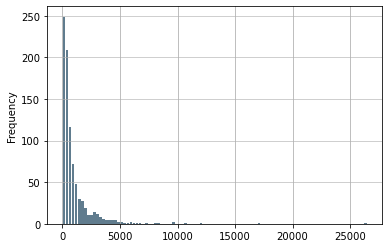

In [13]:
# 看讚數的分佈 y 軸是該讚數的貼文數 來看我們要怎麼取哪個讚數區間資料
commutes = lo_post['like_count']
commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [14]:
temp = lo_post[(lo_post['like_count'] <= 500) & (lo_post['like_count'] > 100)] #讚數大於500 小於1000才取 : 201  篇文章
temp

,new_date,message,jieba_results,like_count
58,2019-07-04,「學音樂的孩子不會變壞」，因為他們比一般的學生有著更多的專注與自律！昨晚出席 海山高中國中部管樂團的成果發表會，讓我更深信這句話。\r\n\r\n雖然不是音樂班學生，而是同學們在每天放學後及周六勤練所組成的社團，但展現的卻是超水準的音樂饗宴，難怪參加校外比賽獲獎無數，到各地交流巡迴表演，更曾在板橋火車站及台中高鐵站快閃演出。\r\n\r\n做為一個音樂愛好者及玩樂器的人，我知道樂器的好壞會影響到學習的興趣與信心。\r\n\r\n所以當家長會林俊星會長向我表示海山管樂團的樂器老舊，管樂室也有待改善時，我立刻答應協助爭取經費，也很高興去年底獲得教育部一百萬元的補助。\r\n\r\n希望新的樂器以及更好的練團環境，可以讓這群愛音樂的小朋友更能大展身手，為我們演出更優美動人的音樂！\r\n\r\n#感謝海山高中管樂團後援會\r\n#懷念大學玩樂團的日子\r\n#我的Bass是Fender,學音樂 的 孩子 不會 變壞 因為 他們 比 一般 的 學生 有 著 更 多 的 專注 與 自律 昨晚 出席 海山 高 中國 中部 管樂團 的 成果 發表會 讓 我 更 深信 這句 話 。 \r\r雖然 不是 音樂班學生 而是 同學們 在 每天 放學後及 周六 勤練 所 組成 的 社團 但展現 的 卻 是 超水準 的 音樂 饗 宴 難怪 參加 校外 比賽 獲獎 無數 到 各地 交流 巡 迴 表演 更 曾 在 板橋 火 車站 及台 中 高鐵站 快 閃 演出 。 \r\r做 為 一個 音樂 愛好者 及 玩樂器 的 人 我 知道 樂器 的 好 壞會 影響 到 學習 的 興趣 與 信心 。 \r\r所以 當家長 會 林俊星 會長 向 我 表示 海山 管樂團 的 樂器 老舊 管樂室 也 有待 改善 時 我 立刻 答應 協助 爭取 經費 也 很 高興 去年底 獲得 教育部 一百 萬元 的 補助 。 \r\r希望 新 的 樂器 以及 更好 的 練團 環境 可以 讓 這群 愛音樂 的 小朋友 更能 大展身手 為 我們 演出 更 優美動 人 的 音樂 \r\r# 感謝 海山 高中 管樂 團後援會 \r# 懷念大學 玩樂團 的 日子 \r# 我 的 是,101
59,2019-04-13,接地氣，有活力😊\r\n\r\n今天參加 妙雲宮。王禪老祖開基祖廟的遶境活動，走了三個半小時，但一點都不累，看到小朋友在路邊拿香拜拜，覺得好感動！\r\n\r\n我把人生比喻成進香，總會遇到腳痛、體力極限種種困難，只要心態正向積極，充滿活力，咬緊牙關撐過去， 一定會到達目的地。\r\n\r\n遇到困難就解決，不到終點不放棄，這是我和神明的約定，也是和自己的約定。💪\r\n\r\n📖小知識：香火鼎盛的板橋妙雲宮，占地350多坪，是板橋地區重要的信仰中心。廟裡供奉的王禪老祖，是春秋戰國時代著名的通才鬼谷子，孫臏、龐涓都是他的弟子。\r\n\r\n#與神同行\r\n#與民同行\r\n#板橋妙雲宮王禪老祖五路財神聯合遶境,接地氣 有 活力 😊 \r\r今天 參加 妙雲宮 。 王禪 老祖 開基祖廟 的 遶 境 活 動 走 了 三個 半小時 但 一點 都 不累 看到 小朋友 在 路邊 拿 香 拜拜 覺得 好感 動 \r\r我 把 人生 比喻 成進 香 總會 遇到 腳痛 體力 極限種種 困難 只要 心態 正向 積極 充滿 活力 咬 緊牙關 撐過 去 一定 會到 達 目的地 。 \r\r遇到 困難 就 解決 不到 終點 不放棄 這是 我 和 神明 的 約定 也 是 和 自己 的 約定 。 💪 \r\r📖 小知識 香火 鼎盛 的 板橋 妙雲宮 占地 多坪 是 板橋 地區 重要 的 信仰 中心 。 廟裡 供奉 的 王禪 老祖 是 春秋 戰國 時代 著名 的 通才 鬼谷子 孫臏 龐 涓 都 是 他 的 弟子 。 \r\r# 與 神 同行 \r# 與民 同行 \r# 板橋 妙雲宮 王禪 老祖 五路 財神 聯合 遶 境,104
60,2019-07-02,您知道學習環境的舒適度與學習成效有相關聯嗎？\r\n\r\n現在的天氣越來越熱，當然會造成孩子們的煩躁心情，\r\n影響他們的專心學習。\r\n\r\n台北市去年宣布中小學教室全面裝設冷氣，\r\n我們新北市的教室卻普遍沒有冷氣，\r\n其中的原因，並不完全是因為買不起冷氣，\r\n而是因為教室電源設備老舊，\r\n需要更大筆的經費來更換。\r\n\r\n去年底我為板橋中山國中爭取到\r\n#教育部400萬元的電源設備改善經費，\r\n學校利用假日期間拼命趕工，\r\n終於在近日完工驗收，\r\n讓八年級30個班的近千位同學，\r\n立刻可以不用再汗流浹背讀書，\r\n而七年級的另外30個班，也將陸續擁有冷氣教室。\r\n\r\n今天來到學校，校長告訴我冷氣完裝得正是時候，因為兩個禮拜之後，暑期輔導班就要開始了，\r\n希望舒適的教室可以讓同學們更專心學習，\r\n考出更好的成績，而這也是我的期待！\r\n\r\n謝謝校長陳君武、家長會長郭妃妃、黃國訓。\r\n\r\n#讓板橋中小學生有冷氣吹\r\n#板橋無限政在實現,您 知道 學習 環境 的 舒 適度 與 學習 成效 有 相關聯 嗎 \r\r現在 的 天氣 越來 越熱 當然會 造成 孩子 們 的 煩躁 心情 \r影響 他們 的 專心 學習 。 \r\r台北市 去年 宣布 中小 學 教室 全面 裝設 冷氣 \r我們 新北市 的 教室 卻 普遍 沒有 冷氣 \r其中 的 原因 並不 完全 是 因為 買 不起 冷氣 \r而是 因為 教室 電源 設備 老舊 \r需要 更大筆 的 經費來 更換 。 \r\r去年底 我為 板橋 中山 國中 爭取 到 \r# 教育部 萬元 的 電源 設備 改善 經費 \r學校 利用 假 日期 間 拼命 趕工 \r終於在 近日 完工 驗收 \r讓 八年 級 個班 的 近 千位 同學 \r立刻 可以 不用 再 汗流 浹 背 讀書 \r而 七年 級 的 另外 個班 也 將陸續 擁有 冷氣 教室 。 \r\r今天 來 到 學校 校長 告訴 我 冷氣 完裝 得 正是 時候 因為 兩個 禮拜 之 後 暑期 輔導班 就要 開始 了 \r希望 舒適 的 教室 可以 讓 同學們 更 專心 學習 \r考 出 更好 的 成績 而 這也 是 我 的 期待 \r\r謝謝 校長 陳 君武 家長 會長 郭妃 妃 黃 國訓 。 \r\r# 讓 板橋 中小 學生 有 冷氣 吹 \r# 板橋 無限政 在 實現,106
61,2019-04-16,午安！來看 蔡英文 Tsai Ing-wen總統的魔術初體驗🎊\r\n\r\n用有趣的方式談嚴肅的議題，才能讓全民共同參與。\r\n\r\n我想跟魔術師 吳何 Horret Wu 說：\r\n\r\n在台灣你可以當面送總統空心菜，\r\n但在中國，你連送習近平包子、在網路說他是小熊維尼的權利都沒有。\r\n\r\n能決定我們未來的人，\r\n不是別人，\r\n就是我們自己。\r\n\r\n🎊魔術影片:https://tinyurl.com/y2decp5a,午安 來 看 蔡英文 - 總統 的 魔術 初體驗 🎊 \r\r用 有趣 的 方式 談 嚴肅 的 議題 才能 讓 全民 共同 參與 。 \r\r我 想 跟 魔術師 吳何 說 \r\r在 台灣 你 可以 當面 送 總統 空心菜 \r但 在 中國 你 連送 習近平 包子 在 網路 說 他 是 小熊 維尼 的 權利 都 沒 有 。 \r\r能 決定 我們 未來 的 人 \r不是 別人 \r就是 我們 自己 。 \r\r🎊 魔術 影片 / / . /,106
62,2019-04-11,報稅5月天，還不清楚新的稅制可以讓你減輕多少負擔嗎？\r\n\r\n跟著路線走，把路過金額加總➡你適用的扣除額度\r\n如果年所得低於合計的扣除額度➡免繳稅。\r\n\r\n（圖片來源： 中華民國財政部 ）\r\n\r\n👉綜所稅線上試算工具：http://bit.ly/2U5UGvf\r\n\r\n#化繁為簡報稅不難,報稅 月 天 還不 清楚 新 的 稅制 可以 讓 你 減輕 多少 負擔 嗎 \r\r跟 著路線 走 把 路過 金額加 總 ➡ 你 適用 的 扣除 額度 \r如果 年 所得 低 於 合計 的 扣除 額度 ➡ 免 繳稅 。 \r\r圖片 來源 中華民國 財政部 \r\r👉 綜所稅 線上 試算 工具 / / . / \r\r# 化繁為簡 報稅 不難,108
...,...,...,...,...
434,2019-07-20,#自由民主永續之旅\r\n#感受僑胞熱情\r\n#丹佛\r\n\r\n剛抵達此次外交之旅的最後一站，美國丹佛。\r\n\r\n不意外，少數中國僑民被動員到蔡英文 Tsai Ing-wen總統下塌丹佛的飯店外抗議。\r\n\r\n意外的是，怎麼連舉牌的標語、輸出字型、喊的口號，都跟紐約那群使用的一樣，實在太沒創意了。\r\n\r\n相較之下，我們一下車就感受到台僑的熱情，而今晚的餐宴，更由原本規劃的四十桌，爆桌到七十桌，從全美各地都有僑胞飛來，甚至還有開兩三天車的，太感謝大家了！,# 自由民主 永續之旅 \r# 感受 僑胞 熱情 \r# 丹佛 \r\r剛抵 達 此次 外交 之旅 的 最 後 一站 美國 丹佛 。 \r\r不 意外 少數 中國 僑民 被 動員到 蔡英文 - 總統 下 塌 丹佛 的 飯店 外抗 議 。 \r\r意外 的 是 

TF-IDF 我們把剛才斷好詞的貼文，轉成list形式，全部放到corpus變數裡面，方便做tf-idf處理。
CountVectorizer算字頻（搭配fit_transform） TfidfTransformer計算TFIDF

In [15]:
corpus = temp['jieba_results'].values.tolist() #如果不做這個、結果會不同 太generall

In [16]:
# TF-IDF
# coding:utf-8  

#算字頻
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  # 計算單字出現在文件中的次數
X = vectorizer.fit_transform(corpus) #  input must be a list, return a matrix (#of corpus) x (# of word) # 201 x 4835
word = vectorizer.get_feature_names() # column name which is the word
message_column = word

#計算TFIDF
from sklearn.feature_extraction.text import TfidfTransformer  # 計算tfidf
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) # X : corpus x word matrix, output:201 x 4835

In [17]:
tfidf_view = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())
tfidf_view

,___,_____,______,一一,一下,一事,一人限購,一代,一件,一位,...,黨政軍及,黨產,黨部,鼎力,鼎盛,鼓勵,鼻孔,齊心,齊聚,龍安里
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.099549,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0.000000,0.0,0.0,0.0,0.088657,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
377,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
378,0.101975,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
379,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [18]:
# #使用LDA演算法
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=8, random_state=None)
LDA.fit(X) # 用countrvectorizer() result 去fit 

topic_message = list()
#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    mes_topic = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(mes_topic)
    for i in mes_topic:
        topic_message.append(i)

TOP 10 WORDS PER TOPIC #0
['爭取', '地下', '公園', '美國', '致政', '停車場', '我們', '中國', '板橋', '台灣']
TOP 10 WORDS PER TOPIC #1
['年輕人', '足球', '大家', '補貼', '今天', '政府', '台灣', '申請', '我們', '板橋']
TOP 10 WORDS PER TOPIC #2
['中共', '今天', '一個', '條例', '板橋', '媒體', '我們', '中國', '香港', '台灣']
TOP 10 WORDS PER TOPIC #3
['警察', '教育', '自己', '教育部', '酒駕', '時間', '課綱', '台灣', '板橋', '致政']
TOP 10 WORDS PER TOPIC #4
['無限政', '實現', '環狀線', '一起', '今天', '致政', '我們', '新北市', '大家', '板橋']
TOP 10 WORDS PER TOPIC #5
['這個', '今天', '媒體', '大家', '國家', '我們', '中國', '總統', '板橋', '台灣']
TOP 10 WORDS PER TOPIC #6
['活動', '無限政', '實現', '加油', '台灣', '大家', '香港', '我們', '致政', '板橋']
TOP 10 WORDS PER TOPIC #7
['可以', '寵物', '就是', '大家', '一起', '今天', '我們', '板橋', '香港', '台灣']


In [19]:
LDA.fit(tfidf) # 用tfidf result 去fit 

#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['苗栗', '大家', '美國', '新聞', '四大', '報頭條', '哪些', '中國', '媒體', '台灣']
TOP 10 WORDS PER TOPIC #1
['新聞', '中國', '接到', '自己', '大公', '台灣', '考生', '形象', '香港', '大家']
TOP 10 WORDS PER TOPIC #2
['開始', '加油', '蔡英文', '繼續', '大家', '我們', '板橋', '香港', '直播', '台灣']
TOP 10 WORDS PER TOPIC #3
['美食', '可以', '直播', '我們', '致政', '活動', '中國', '香港', '板橋', '台灣']
TOP 10 WORDS PER TOPIC #4
['直播', '幾天', '韓國瑜', '知道', '大家', '俱樂部', '老人', '我們', '香港', '台灣']
TOP 10 WORDS PER TOPIC #5
['板橋', '條例', '大家', '問政', '蔡英文', '致政', '總統', '中國', '台灣', '香港']
TOP 10 WORDS PER TOPIC #6
['道路', '蔡英文', '美國', '我們', '中國', '政府', '總統', '聖文森', '足球', '台灣']
TOP 10 WORDS PER TOPIC #7
['補助', '無限政', '我們', '實現', '爭取', '致政', '地下', '公園', '停車場', '板橋']


In [20]:
#政見做斷詞

politics_liu = politics[politics.姓名 == "羅 致 政"].政見.to_string()
#politics_liu = politics[politics.姓名 == "吳思瑤"].政見.to_string()

politics_liu = re.sub(re_punctuation, "", politics_liu)
politics_liu = re.sub(r'[0-9]','',politics_liu)
politics_liu = re.sub(r'[a-zA-Z]','',politics_liu)
politics_liu = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗、，」「（）]','',politics_liu)  # 注意裡面不能有空白！
jieba.load_userdict("dict.txt")
politics_words = jieba.lcut(politics_liu, cut_all = False)


In [21]:
#觀察政見的斷詞結果
inspect_words = jieba.cut(politics_liu, cut_all = False)
text = ''
for word in inspect_words:
    text = text + ' ' + str(word) 
text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗+]','',text)
text = re.sub(re_punctuation, "", text)
text

'         改變 是 這些 年 最響 亮 的 政治 廣告 口號 但 要 改變 什麼 呢 四年 前當 我決   定 繼續 在 板橋 基層 深耕 後 就 深刻 體認 我 不再 是 一個 可以 隱遁 在 寧靜校 園裡 的   大學 老師 我 必須 和 大家 一起 呼吸 勇敢 面對 人世 間 的 不義和苦 難 這些 年 來 我 選擇 以無給 職 的 新北市 黨部 主委 做 為 舞台 全力 為民眾 和 公職 人員 搭 好 溝通 的   橋 樑 我 深切 體認 大家 想 改變 的 不是 只換個 政黨 執政 而已 而是 有 權力 的 人 可   以 用心 讓 小市民 生活 過得 更好   這是 我 的 從政 初衷 沒有 派系 也 不是 政治 世家 選擇 從 校園 踏進 政治 圈 答案 始終 只有 一個 就是 為 了 實踐 理想 羅致政 承諾將 以 正直 理性 問政 人民   福祉 優先 的 理念 來 落實 國會 改革 與 為民 服務 的 目標 一 國會 改革   １   以 國家 和 人民 的 利益 為 先政黨 和 個 人 的 利益 為 後   ２   國會 運作 公開 透明 讓 立法院 不再 有 密室 政治 黑箱 運作 的 空間 提高 立法   院 問政 效率   ３   修法 降低 公投法 和 修憲門檻 實現 歲 投票 權訴 求 保障 直接 民權 補足代   議 制度 的 缺陷   二為民 服務   １   推動 十年 長照 計畫 落實 長照 托育 女性 就業 三合一 照顧 政策 減輕婦 女照 顧 重擔   ２   推動 食安五環 計畫 從 食品 源頭 就 全面 監控 對 黑心 廠商 課以 更重 的 法   律責任   ３   配合 五大 創新 研發 計畫 調整 高等教育 階段 的 課程 與 科系 解決 大學 畢   業生 學用 落差 問題   ４   提供 只租 不售 的 高品質 青年 社會住宅 並針 對 特殊 居住 要求 以及 弱勢 者 提供   補助   ５   確保國 內 文化 多樣 性積極 保存 維護 和 活化 有形 及 非物質 的 文化 資產'

In [22]:
# 政見做tfidf
p_vectorizer = CountVectorizer()  
p_X = p_vectorizer.fit_transform(politics_words)  
p_colword = p_vectorizer.get_feature_names() 
p_transformer = TfidfTransformer()  
p_tfidf = p_transformer.fit_transform(p_X) #143 word in 

p_LDA = LatentDirichletAllocation(n_components=8, random_state=None)

# 政見做LDA
p_LDA.fit(p_tfidf)
topic_politics = list()
#觀看結果
for i,topic in enumerate(p_LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    topic_p = [p_vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(topic_p)
    for i in topic_p:
        topic_politics.append(i)

TOP 10 WORDS PER TOPIC #0
['正直', '更好', '學用', '隱遁', '福祉', '更重', '必須', '什麼', '體認', '政治']
TOP 10 WORDS PER TOPIC #1
['最響', '園裡', '一起', '理想', '補足代', '補助', '生活', '廠商', '公開', '課以']
TOP 10 WORDS PER TOPIC #2
['十年', '答案', '目標', '階段', '特殊', '繼續', '人世', '修法', '落實', '這些']
TOP 10 WORDS PER TOPIC #3
['踏進', '政策', '立法院', '律責任', '要求', '只換個', '提供', '推動', '利益', '服務']
TOP 10 WORDS PER TOPIC #4
['舞台', '重擔', '維護', '實現', '就是', '就業', '用心', '減輕婦', '大學', '改變']
TOP 10 WORDS PER TOPIC #5
['提高', '研發', '全力', '四年', '制度', '理性', '改革', '大家', '不再', '國會']
TOP 10 WORDS PER TOPIC #6
['承諾將', '新北市', '基層', '民權', '這是', '國家', '先政黨', '文化', '不是', '一個']
TOP 10 WORDS PER TOPIC #7
['政黨', '前當', '板橋', '社會住宅', '運作', '人民', '選擇', '長照', '問政', '計畫']


In [23]:
# #政見所有topic 總表
for i in topic_politics:
#for i in topic_:# 文章內容的topic所有字的總表
    print(i,end = ', ')

正直, 更好, 學用, 隱遁, 福祉, 更重, 必須, 什麼, 體認, 政治, 最響, 園裡, 一起, 理想, 補足代, 補助, 生活, 廠商, 公開, 課以, 十年, 答案, 目標, 階段, 特殊, 繼續, 人世, 修法, 落實, 這些, 踏進, 政策, 立法院, 律責任, 要求, 只換個, 提供, 推動, 利益, 服務, 舞台, 重擔, 維護, 實現, 就是, 就業, 用心, 減輕婦, 大學, 改變, 提高, 研發, 全力, 四年, 制度, 理性, 改革, 大家, 不再, 國會, 承諾將, 新北市, 基層, 民權, 這是, 國家, 先政黨, 文化, 不是, 一個, 政黨, 前當, 板橋, 社會住宅, 運作, 人民, 選擇, 長照, 問政, 計畫, 

In [24]:
#在LDA結果中每個Topic政見的詞 、 臉書貼文的詞的交集 
#set(topic_politics).intersection(topic_message) 
Counter(topic_politics+topic_message) #綜合臉書發文、政見 Topic 的詞 看出現次數
#產業升級、園區、高科技園區、加工區 、楠梓、交通、三鐵同構

Counter({'正直': 1,
         '更好': 1,
         '學用': 1,
         '隱遁': 1,
         '福祉': 1,
         '更重': 1,
         '必須': 1,
         '什麼': 1,
         '體認': 1,
         '政治': 1,
         '最響': 1,
         '園裡': 1,
         '一起': 3,
         '理想': 1,
         '補足代': 1,
         '補助': 1,
         '生活': 1,
         '廠商': 1,
         '公開': 1,
         '課以': 1,
         '十年': 1,
         '答案': 1,
         '目標': 1,
         '階段': 1,
         '特殊': 1,
         '繼續': 1,
         '人世': 1,
         '修法': 1,
         '落實': 1,
         '這些': 1,
         '踏進': 1,
         '政策': 1,
         '立法院': 1,
         '律責任': 1,
         '要求': 1,
         '只換個': 1,
         '提供': 1,
         '推動': 1,
         '利益': 1,
         '服務': 1,
         '舞台': 1,
         '重擔': 1,
         '維護': 1,
         '實現': 3,
         '就是': 2,
         '就業': 1,
         '用心': 1,
         '減輕婦': 1,
         '大學': 1,
         '改變': 1,
         '提高': 1,
         '研發': 1,
         '全力': 1,
         '四年': 1,
         '制度': 1,
     

In [52]:
top_10_message = tfidf_view.sort_values(by = ['社會住宅'], ascending = False).index[:10] # 把高科技tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['社會住宅'], ascending = False).head(10)

,___,_____,______,一一,一下,一事,一人限購,一代,一件,一位,...,黨產,黨部,鼎力,鼎盛,鼓勵,鼻孔,齊心,齊聚,龍安里,term
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,加薪
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,樂器
262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,暢快
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,造勢
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,半看
258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,彩券
257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,三重
256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,恐嚇
255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,酒駕
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,戰車


In [53]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[17,]).sort_values(by = 17, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

In [35]:
#politics_word
match_column = list(set(politics_words).intersection(vectorizer.get_feature_names()))
match_column

['深刻',
 '而是',
 '效率',
 '課程',
 '降低',
 '配合',
 '特殊',
 '修法',
 '女性',
 '目標',
 '什麼',
 '解決',
 '社會住宅',
 '研發',
 '以及',
 '就是',
 '利益',
 '權力',
 '計畫',
 '補助',
 '就業',
 '制度',
 '人民',
 '提供',
 '老師',
 '公開',
 '青年',
 '選擇',
 '文化',
 '黨部',
 '只有',
 '提高',
 '投票',
 '更好',
 '活化',
 '繼續',
 '板橋',
 '大家',
 '階段',
 '資產',
 '校園',
 '生活',
 '實現',
 '人員',
 '實踐',
 '弱勢',
 '推動',
 '勇敢',
 '三合一',
 '十年',
 '新北市',
 '不再',
 '全面',
 '國會',
 '不是',
 '政策',
 '執政',
 '必須',
 '政治',
 '大學',
 '問題',
 '問政',
 '全力',
 '要求',
 '空間',
 '四年',
 '這是',
 '用心',
 '沒有',
 '初衷',
 '而已',
 '調整',
 '面對',
 '羅致政',
 '立法',
 '廣告',
 '一個',
 '優先',
 '過得',
 '主委',
 '口號',
 '改革',
 '基層',
 '落實',
 '深耕',
 '監控',
 '答案',
 '國家',
 '改變',
 '直接',
 '照顧',
 '這些',
 '理念',
 '一起',
 '可以',
 '政黨',
 '為民眾',
 '托育',
 '長照',
 '保障',
 '服務',
 '立法院',
 '創新']

In [28]:
#politics_word
match_column = list(set(words).intersection(vectorizer.get_feature_names()))
match_column

[]

In [36]:
document_term_fb = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
document_term_fb

,___,_____,______,一一,一下,一事,一人限購,一代,一件,一位,...,黨政軍及,黨產,黨部,鼎力,鼎盛,鼓勵,鼻孔,齊心,齊聚,龍安里
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
378,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#確認term matrix是對的  檢查第200篇貼文真的有”一個“這個詞 
temp.iloc[376,]

new_date                                                                                                                                                                                                                                                                                                                   2019-07-20
message                                                                             #自由民主永續之旅\r\n#感受僑胞熱情\r\n#丹佛\r\n\r\n剛抵達此次外交之旅的最後一站，美國丹佛。\r\n\r\n不意外，少數中國僑民被動員到蔡英文 Tsai Ing-wen總統下塌丹佛的飯店外抗議。\r\n\r\n意外的是，怎麼連舉牌的標語、輸出字型、喊的口號，都跟紐約那群使用的一樣，實在太沒創意了。\r\n\r\n相較之下，我們一下車就感受到台僑的熱情，而今晚的餐宴，更由原本規劃的四十桌，爆桌到七十桌，從全美各地都有僑胞飛來，甚至還有開兩三天車的，太感謝大家了！
jieba_results     # 自由民主 永續之旅 \r# 感受 僑胞 熱情 \r# 丹佛 \r\r剛抵 達 此次 外交 之旅 的 最 後 一站 美國 丹佛 。 \r\r不 意外 少數 中國 僑民 被 動員到 蔡英文       -  總統 下 塌 丹佛 的 飯店 外抗 議 。 \r\r意外 的 是 怎麼 連舉牌 的 標語 輸出 字型 喊 的 口號 都 跟 紐約 那群 使用 的 一樣 實在 太 沒 創意 了 。 \r\r相較 之下 我們 一下 車就 感受 到 台僑 的 熱情 而 今晚 的 餐宴 更 由 原本 規劃 的 四十 桌 爆桌 到 七十 桌 從 全美 各地 都 有 僑胞 飛來 甚至 還有 開 兩 三天 車的 太感謝 大家 了 ！
like_count            

In [38]:
match_document_politics = document_term_fb[match_column]
match_document_politics

,深刻,而是,效率,課程,降低,配合,特殊,修法,女性,目標,...,一起,可以,政黨,為民眾,托育,長照,保障,服務,立法院,創新
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
378,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
379,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [40]:
match_document_politics["sum"] = match_document_politics.sum(axis=1)
match_document_politics

<ipython-input-40-1ded51f200cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_document_politics["sum"] = match_document_politics.sum(axis=1)


,深刻,而是,效率,課程,降低,配合,特殊,修法,女性,目標,...,可以,政黨,為民眾,托育,長照,保障,服務,立法院,創新,sum
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,16
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,0,1,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,22
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
377,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12
379,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4


In [41]:
sum(match_document_politics['sum'].tolist()) / len(match_column) #381篇中會有34篇有包含政策相關的

34.52427184466019

In [43]:
sum(match_document_politics['sum'].tolist()) / len(match_column) /len(temp) # 相關度9.1%

0.09061488673139158